# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

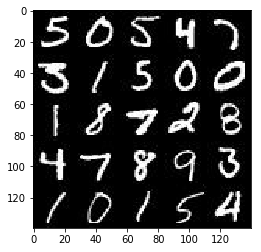

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

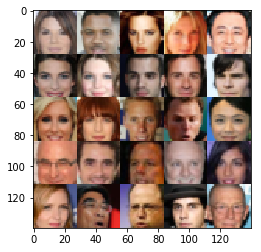

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z(G input)
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input_images')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        drop = tf.layers.dropout(relu1, rate=0.2)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128        
        drop = tf.layers.dropout(relu2, rate=0.2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256        
        drop = tf.layers.dropout(relu3, rate=0.2)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        drop = tf.layers.dropout(x1, rate=0.2, training=is_train)

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        drop = tf.layers.dropout(x1, rate=0.2, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        drop = tf.layers.dropout(x1, rate=0.2, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now

        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # batch_images=>each_image 
    #Get images, reshape and rescale to pass to D

    
    #transfer data_shape to image data for D
    number_of_data, image_width, image_height, image_channels = data_shape            
    
    #set up placeholders
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
                                
    #calculate                                            
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
                
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                #np.min(batch_images) = -0.5/np.max(batch_images) = 0.5
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.8933... Generator Loss: 0.9953
Epoch 0/2... Discriminator Loss: 0.4774... Generator Loss: 1.7641
Epoch 0/2... Discriminator Loss: 0.2068... Generator Loss: 2.3861
Epoch 0/2... Discriminator Loss: 0.2045... Generator Loss: 2.2306
Epoch 0/2... Discriminator Loss: 0.4753... Generator Loss: 1.7223
Epoch 0/2... Discriminator Loss: 0.2096... Generator Loss: 2.2385
Epoch 0/2... Discriminator Loss: 0.9441... Generator Loss: 1.3327
Epoch 0/2... Discriminator Loss: 0.2004... Generator Loss: 2.6280
Epoch 0/2... Discriminator Loss: 0.2463... Generator Loss: 2.0295
Epoch 0/2... Discriminator Loss: 0.6328... Generator Loss: 1.4178


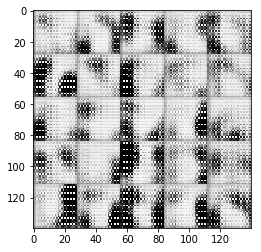

Epoch 0/2... Discriminator Loss: 1.9006... Generator Loss: 0.2349
Epoch 0/2... Discriminator Loss: 1.7804... Generator Loss: 0.2876
Epoch 0/2... Discriminator Loss: 0.8389... Generator Loss: 0.9564
Epoch 0/2... Discriminator Loss: 1.2014... Generator Loss: 1.6385
Epoch 0/2... Discriminator Loss: 1.6702... Generator Loss: 0.3458
Epoch 0/2... Discriminator Loss: 1.1340... Generator Loss: 1.4458
Epoch 0/2... Discriminator Loss: 1.2776... Generator Loss: 1.1774
Epoch 0/2... Discriminator Loss: 1.2063... Generator Loss: 0.8401
Epoch 0/2... Discriminator Loss: 1.3657... Generator Loss: 1.1066
Epoch 0/2... Discriminator Loss: 1.6067... Generator Loss: 0.6826


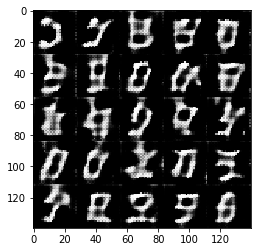

Epoch 0/2... Discriminator Loss: 1.3073... Generator Loss: 0.7031
Epoch 0/2... Discriminator Loss: 1.2034... Generator Loss: 0.8031
Epoch 0/2... Discriminator Loss: 1.2191... Generator Loss: 0.7939
Epoch 0/2... Discriminator Loss: 1.0946... Generator Loss: 0.8560
Epoch 0/2... Discriminator Loss: 1.3199... Generator Loss: 0.9370
Epoch 0/2... Discriminator Loss: 1.2483... Generator Loss: 0.8189
Epoch 0/2... Discriminator Loss: 1.4245... Generator Loss: 0.5911
Epoch 0/2... Discriminator Loss: 1.2864... Generator Loss: 0.6800
Epoch 0/2... Discriminator Loss: 1.5975... Generator Loss: 0.3929
Epoch 0/2... Discriminator Loss: 1.2684... Generator Loss: 0.7932


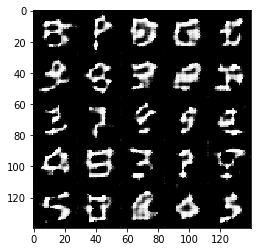

Epoch 0/2... Discriminator Loss: 1.3270... Generator Loss: 0.6848
Epoch 0/2... Discriminator Loss: 1.2513... Generator Loss: 0.7725
Epoch 0/2... Discriminator Loss: 1.4531... Generator Loss: 0.4164
Epoch 0/2... Discriminator Loss: 1.3473... Generator Loss: 0.8148
Epoch 0/2... Discriminator Loss: 1.3635... Generator Loss: 0.5228
Epoch 0/2... Discriminator Loss: 1.4135... Generator Loss: 0.6046
Epoch 0/2... Discriminator Loss: 1.3949... Generator Loss: 0.4669
Epoch 0/2... Discriminator Loss: 1.3307... Generator Loss: 1.2606
Epoch 0/2... Discriminator Loss: 1.3334... Generator Loss: 0.9962
Epoch 0/2... Discriminator Loss: 1.1557... Generator Loss: 0.7077


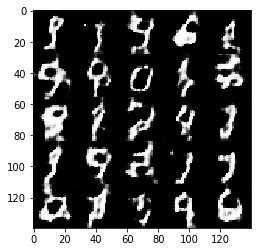

Epoch 0/2... Discriminator Loss: 1.2634... Generator Loss: 0.9133
Epoch 0/2... Discriminator Loss: 1.3047... Generator Loss: 0.6963
Epoch 0/2... Discriminator Loss: 1.2550... Generator Loss: 0.5768
Epoch 0/2... Discriminator Loss: 1.3780... Generator Loss: 0.7167
Epoch 0/2... Discriminator Loss: 1.3285... Generator Loss: 0.6240
Epoch 0/2... Discriminator Loss: 1.5978... Generator Loss: 0.3969
Epoch 0/2... Discriminator Loss: 1.2753... Generator Loss: 0.7950
Epoch 0/2... Discriminator Loss: 1.1978... Generator Loss: 0.9903
Epoch 0/2... Discriminator Loss: 1.2270... Generator Loss: 0.7565
Epoch 0/2... Discriminator Loss: 1.3940... Generator Loss: 0.6445


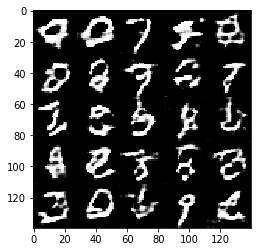

Epoch 0/2... Discriminator Loss: 1.2776... Generator Loss: 0.7781
Epoch 0/2... Discriminator Loss: 1.4340... Generator Loss: 0.4401
Epoch 0/2... Discriminator Loss: 1.3395... Generator Loss: 0.5473
Epoch 0/2... Discriminator Loss: 1.3585... Generator Loss: 0.9518
Epoch 0/2... Discriminator Loss: 1.2679... Generator Loss: 0.7158
Epoch 0/2... Discriminator Loss: 1.2003... Generator Loss: 0.7035
Epoch 0/2... Discriminator Loss: 1.3068... Generator Loss: 0.8036
Epoch 0/2... Discriminator Loss: 1.5229... Generator Loss: 0.3779
Epoch 0/2... Discriminator Loss: 1.2214... Generator Loss: 0.8659
Epoch 0/2... Discriminator Loss: 1.2865... Generator Loss: 1.0408


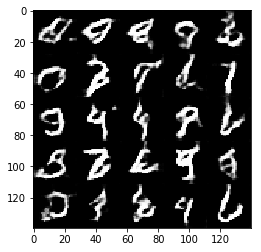

Epoch 0/2... Discriminator Loss: 1.2259... Generator Loss: 0.5880
Epoch 0/2... Discriminator Loss: 1.1319... Generator Loss: 0.7412
Epoch 0/2... Discriminator Loss: 1.3153... Generator Loss: 0.9559
Epoch 0/2... Discriminator Loss: 1.2589... Generator Loss: 0.5867
Epoch 0/2... Discriminator Loss: 1.2802... Generator Loss: 0.7837
Epoch 0/2... Discriminator Loss: 1.8251... Generator Loss: 0.5104
Epoch 0/2... Discriminator Loss: 1.2049... Generator Loss: 0.8203
Epoch 0/2... Discriminator Loss: 1.2271... Generator Loss: 0.7567
Epoch 0/2... Discriminator Loss: 1.3132... Generator Loss: 0.7588
Epoch 0/2... Discriminator Loss: 1.2602... Generator Loss: 0.6142


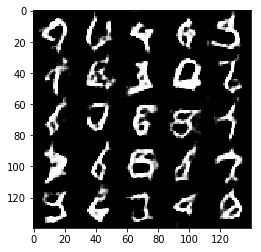

Epoch 0/2... Discriminator Loss: 1.3043... Generator Loss: 1.0754
Epoch 0/2... Discriminator Loss: 1.2555... Generator Loss: 0.6259
Epoch 0/2... Discriminator Loss: 1.1695... Generator Loss: 0.6638
Epoch 0/2... Discriminator Loss: 1.3802... Generator Loss: 0.5149
Epoch 0/2... Discriminator Loss: 1.2432... Generator Loss: 1.0491
Epoch 0/2... Discriminator Loss: 1.2525... Generator Loss: 0.8791
Epoch 0/2... Discriminator Loss: 1.6597... Generator Loss: 1.3064
Epoch 0/2... Discriminator Loss: 1.3955... Generator Loss: 0.5700
Epoch 0/2... Discriminator Loss: 1.2541... Generator Loss: 0.9358
Epoch 0/2... Discriminator Loss: 1.8041... Generator Loss: 1.4115


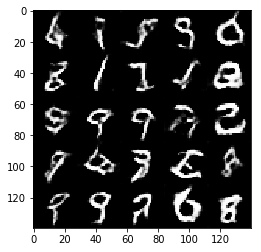

Epoch 0/2... Discriminator Loss: 1.4884... Generator Loss: 0.9423
Epoch 0/2... Discriminator Loss: 1.2465... Generator Loss: 0.7616
Epoch 0/2... Discriminator Loss: 1.1599... Generator Loss: 0.8951
Epoch 0/2... Discriminator Loss: 1.1585... Generator Loss: 0.8774
Epoch 0/2... Discriminator Loss: 1.9380... Generator Loss: 0.6964
Epoch 0/2... Discriminator Loss: 1.2949... Generator Loss: 0.7920
Epoch 0/2... Discriminator Loss: 1.1853... Generator Loss: 0.6978
Epoch 0/2... Discriminator Loss: 1.2261... Generator Loss: 0.7544
Epoch 0/2... Discriminator Loss: 1.7451... Generator Loss: 1.5368
Epoch 0/2... Discriminator Loss: 1.2862... Generator Loss: 0.7364


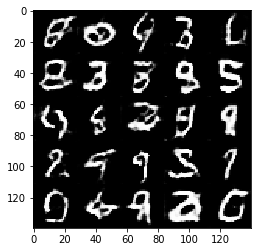

Epoch 0/2... Discriminator Loss: 1.4039... Generator Loss: 0.9170
Epoch 0/2... Discriminator Loss: 1.3248... Generator Loss: 0.6447
Epoch 0/2... Discriminator Loss: 1.2662... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 1.6049
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.9728
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.5415... Generator Loss: 0.3766


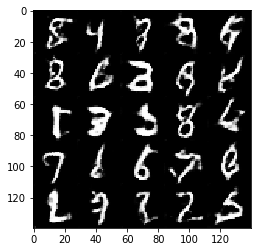

Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.5943


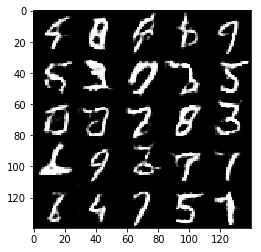

Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.4881
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 1.9943... Generator Loss: 2.0511
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.6361... Generator Loss: 0.3204
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 0.7133


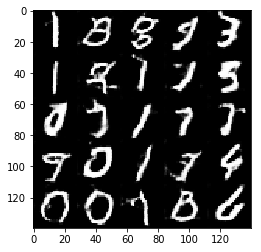

Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 1.4046
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 1.2813
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.8332


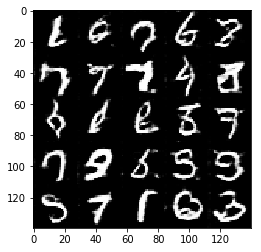

Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 1.6759


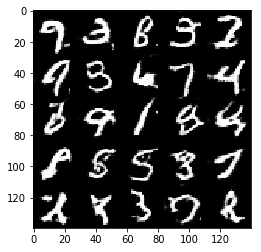

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 1.0044
Epoch 1/2... Discriminator Loss: 1.6734... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 2.7269... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.7674... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.8101


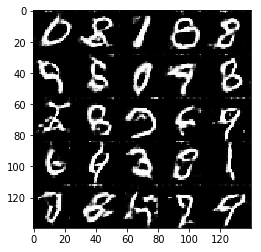

Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.7267
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.8615


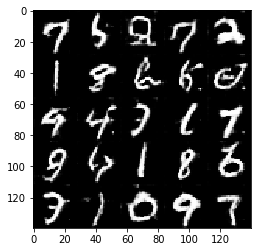

Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.4771
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.8832
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.1297


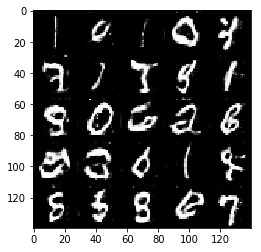

Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.7403


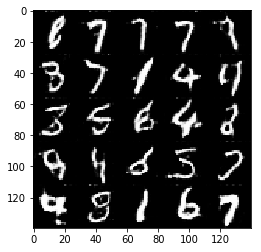

Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 1.2731
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.1076


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.1633... Generator Loss: 0.9792
Epoch 0/1... Discriminator Loss: 0.7800... Generator Loss: 1.4400
Epoch 0/1... Discriminator Loss: 0.8470... Generator Loss: 1.5583
Epoch 0/1... Discriminator Loss: 0.7228... Generator Loss: 1.1978
Epoch 0/1... Discriminator Loss: 0.5972... Generator Loss: 2.4478
Epoch 0/1... Discriminator Loss: 0.8590... Generator Loss: 1.6683
Epoch 0/1... Discriminator Loss: 0.2291... Generator Loss: 2.2034
Epoch 0/1... Discriminator Loss: 0.2208... Generator Loss: 1.9507
Epoch 0/1... Discriminator Loss: 0.6820... Generator Loss: 1.1331
Epoch 0/1... Discriminator Loss: 1.0551... Generator Loss: 0.8886


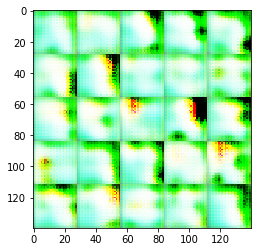

Epoch 0/1... Discriminator Loss: 1.5086... Generator Loss: 0.8805
Epoch 0/1... Discriminator Loss: 0.5107... Generator Loss: 1.2989
Epoch 0/1... Discriminator Loss: 0.6783... Generator Loss: 1.3483
Epoch 0/1... Discriminator Loss: 0.4109... Generator Loss: 2.4415
Epoch 0/1... Discriminator Loss: 5.3901... Generator Loss: 2.5445
Epoch 0/1... Discriminator Loss: 0.4064... Generator Loss: 1.7680
Epoch 0/1... Discriminator Loss: 0.9085... Generator Loss: 1.8634
Epoch 0/1... Discriminator Loss: 1.3608... Generator Loss: 0.7989
Epoch 0/1... Discriminator Loss: 1.0317... Generator Loss: 1.0047
Epoch 0/1... Discriminator Loss: 1.1192... Generator Loss: 0.8063


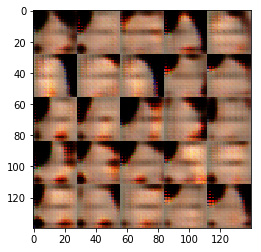

Epoch 0/1... Discriminator Loss: 1.3989... Generator Loss: 0.6587
Epoch 0/1... Discriminator Loss: 1.4300... Generator Loss: 0.7787
Epoch 0/1... Discriminator Loss: 1.4116... Generator Loss: 0.6226
Epoch 0/1... Discriminator Loss: 1.2712... Generator Loss: 0.7353
Epoch 0/1... Discriminator Loss: 1.0904... Generator Loss: 0.8146
Epoch 0/1... Discriminator Loss: 1.2074... Generator Loss: 0.8527
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 0.8097
Epoch 0/1... Discriminator Loss: 1.1434... Generator Loss: 0.9522
Epoch 0/1... Discriminator Loss: 1.1934... Generator Loss: 0.6281
Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.7614


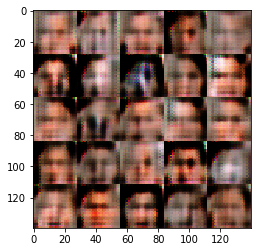

Epoch 0/1... Discriminator Loss: 1.4845... Generator Loss: 0.4966
Epoch 0/1... Discriminator Loss: 1.3513... Generator Loss: 0.6060
Epoch 0/1... Discriminator Loss: 1.2279... Generator Loss: 0.8922
Epoch 0/1... Discriminator Loss: 1.4286... Generator Loss: 0.7433
Epoch 0/1... Discriminator Loss: 1.3880... Generator Loss: 0.9817
Epoch 0/1... Discriminator Loss: 1.6162... Generator Loss: 0.9009
Epoch 0/1... Discriminator Loss: 1.4516... Generator Loss: 0.5009
Epoch 0/1... Discriminator Loss: 1.3210... Generator Loss: 1.1928
Epoch 0/1... Discriminator Loss: 1.3661... Generator Loss: 0.5732
Epoch 0/1... Discriminator Loss: 1.5106... Generator Loss: 0.9116


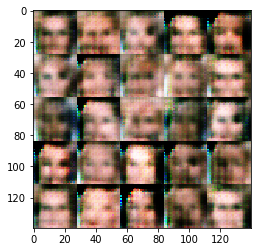

Epoch 0/1... Discriminator Loss: 1.6834... Generator Loss: 0.6868
Epoch 0/1... Discriminator Loss: 1.3578... Generator Loss: 0.6520
Epoch 0/1... Discriminator Loss: 1.2761... Generator Loss: 0.9041
Epoch 0/1... Discriminator Loss: 1.4250... Generator Loss: 0.4510
Epoch 0/1... Discriminator Loss: 1.4366... Generator Loss: 0.5802
Epoch 0/1... Discriminator Loss: 1.3082... Generator Loss: 0.9277
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 0.8458
Epoch 0/1... Discriminator Loss: 1.2960... Generator Loss: 0.8738
Epoch 0/1... Discriminator Loss: 1.0169... Generator Loss: 0.8455
Epoch 0/1... Discriminator Loss: 2.0141... Generator Loss: 0.7434


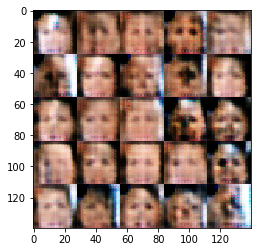

Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.7534
Epoch 0/1... Discriminator Loss: 1.3048... Generator Loss: 0.5697
Epoch 0/1... Discriminator Loss: 1.3369... Generator Loss: 0.5931
Epoch 0/1... Discriminator Loss: 1.5129... Generator Loss: 0.3716
Epoch 0/1... Discriminator Loss: 1.1896... Generator Loss: 0.9863
Epoch 0/1... Discriminator Loss: 1.2991... Generator Loss: 0.5844
Epoch 0/1... Discriminator Loss: 1.5743... Generator Loss: 1.2688
Epoch 0/1... Discriminator Loss: 1.2990... Generator Loss: 1.1043
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.6566
Epoch 0/1... Discriminator Loss: 1.2065... Generator Loss: 0.7807


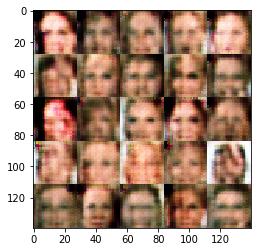

Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.8664
Epoch 0/1... Discriminator Loss: 1.2645... Generator Loss: 0.7558
Epoch 0/1... Discriminator Loss: 1.2548... Generator Loss: 0.9221
Epoch 0/1... Discriminator Loss: 1.2716... Generator Loss: 0.4994
Epoch 0/1... Discriminator Loss: 1.4946... Generator Loss: 0.4491
Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 0.5820
Epoch 0/1... Discriminator Loss: 1.4089... Generator Loss: 0.9619
Epoch 0/1... Discriminator Loss: 1.4255... Generator Loss: 0.4569
Epoch 0/1... Discriminator Loss: 1.2821... Generator Loss: 0.6877
Epoch 0/1... Discriminator Loss: 1.1784... Generator Loss: 1.1684


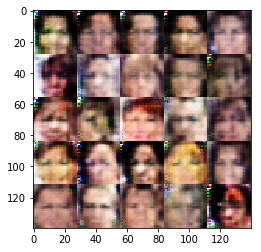

Epoch 0/1... Discriminator Loss: 1.2959... Generator Loss: 0.8080
Epoch 0/1... Discriminator Loss: 1.3938... Generator Loss: 0.8219
Epoch 0/1... Discriminator Loss: 1.3169... Generator Loss: 0.8563
Epoch 0/1... Discriminator Loss: 1.2601... Generator Loss: 0.5703
Epoch 0/1... Discriminator Loss: 1.1882... Generator Loss: 0.7588
Epoch 0/1... Discriminator Loss: 1.3693... Generator Loss: 0.5934
Epoch 0/1... Discriminator Loss: 1.2952... Generator Loss: 0.9926
Epoch 0/1... Discriminator Loss: 1.6612... Generator Loss: 0.3354
Epoch 0/1... Discriminator Loss: 1.1444... Generator Loss: 1.0164
Epoch 0/1... Discriminator Loss: 1.6493... Generator Loss: 0.5633


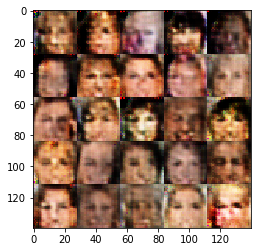

Epoch 0/1... Discriminator Loss: 1.2290... Generator Loss: 0.9721
Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 1.3542
Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.9745
Epoch 0/1... Discriminator Loss: 1.2090... Generator Loss: 0.7619
Epoch 0/1... Discriminator Loss: 1.2090... Generator Loss: 0.9084
Epoch 0/1... Discriminator Loss: 1.6257... Generator Loss: 0.4920
Epoch 0/1... Discriminator Loss: 1.2988... Generator Loss: 0.8472
Epoch 0/1... Discriminator Loss: 1.4522... Generator Loss: 1.2782
Epoch 0/1... Discriminator Loss: 1.3961... Generator Loss: 0.6465
Epoch 0/1... Discriminator Loss: 1.2263... Generator Loss: 0.8774


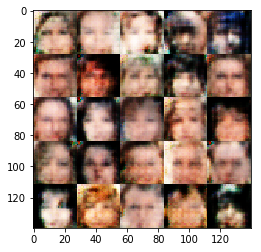

Epoch 0/1... Discriminator Loss: 1.4871... Generator Loss: 0.5549
Epoch 0/1... Discriminator Loss: 1.3469... Generator Loss: 0.5435
Epoch 0/1... Discriminator Loss: 1.2813... Generator Loss: 0.6509
Epoch 0/1... Discriminator Loss: 1.2939... Generator Loss: 0.9750
Epoch 0/1... Discriminator Loss: 1.4493... Generator Loss: 1.1743
Epoch 0/1... Discriminator Loss: 1.4816... Generator Loss: 1.1848
Epoch 0/1... Discriminator Loss: 1.1418... Generator Loss: 0.7476
Epoch 0/1... Discriminator Loss: 1.3399... Generator Loss: 0.7275
Epoch 0/1... Discriminator Loss: 1.3189... Generator Loss: 0.8606
Epoch 0/1... Discriminator Loss: 1.3390... Generator Loss: 1.0482


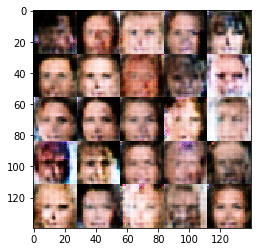

Epoch 0/1... Discriminator Loss: 1.1769... Generator Loss: 0.9515
Epoch 0/1... Discriminator Loss: 1.3300... Generator Loss: 0.7117
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.6617
Epoch 0/1... Discriminator Loss: 1.4466... Generator Loss: 0.6038
Epoch 0/1... Discriminator Loss: 1.3665... Generator Loss: 0.8074
Epoch 0/1... Discriminator Loss: 1.4363... Generator Loss: 0.5951
Epoch 0/1... Discriminator Loss: 1.1669... Generator Loss: 0.8120
Epoch 0/1... Discriminator Loss: 1.3453... Generator Loss: 0.9668
Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.6033
Epoch 0/1... Discriminator Loss: 1.1415... Generator Loss: 0.7864


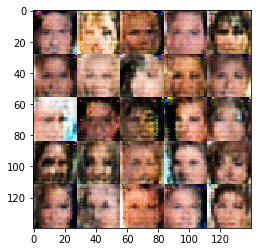

Epoch 0/1... Discriminator Loss: 1.2918... Generator Loss: 0.6410
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.7760
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.9736
Epoch 0/1... Discriminator Loss: 1.3785... Generator Loss: 0.8231
Epoch 0/1... Discriminator Loss: 1.4724... Generator Loss: 0.5794
Epoch 0/1... Discriminator Loss: 1.3153... Generator Loss: 0.5833
Epoch 0/1... Discriminator Loss: 1.5418... Generator Loss: 0.5922
Epoch 0/1... Discriminator Loss: 1.2803... Generator Loss: 0.6949
Epoch 0/1... Discriminator Loss: 1.4652... Generator Loss: 0.4868
Epoch 0/1... Discriminator Loss: 1.2868... Generator Loss: 0.9351


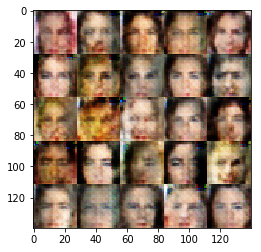

Epoch 0/1... Discriminator Loss: 1.3147... Generator Loss: 0.7889
Epoch 0/1... Discriminator Loss: 1.5491... Generator Loss: 0.8939
Epoch 0/1... Discriminator Loss: 1.3282... Generator Loss: 0.6800
Epoch 0/1... Discriminator Loss: 1.4238... Generator Loss: 0.4072
Epoch 0/1... Discriminator Loss: 1.3483... Generator Loss: 0.6184
Epoch 0/1... Discriminator Loss: 1.3453... Generator Loss: 0.5130
Epoch 0/1... Discriminator Loss: 1.2919... Generator Loss: 0.5652
Epoch 0/1... Discriminator Loss: 1.4279... Generator Loss: 0.4943
Epoch 0/1... Discriminator Loss: 1.2889... Generator Loss: 0.6398
Epoch 0/1... Discriminator Loss: 1.4987... Generator Loss: 0.5741


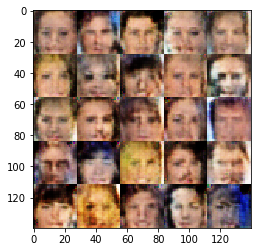

Epoch 0/1... Discriminator Loss: 1.4248... Generator Loss: 0.5606
Epoch 0/1... Discriminator Loss: 1.5958... Generator Loss: 0.3309
Epoch 0/1... Discriminator Loss: 1.2750... Generator Loss: 0.6606
Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 1.0309
Epoch 0/1... Discriminator Loss: 1.5214... Generator Loss: 1.4229
Epoch 0/1... Discriminator Loss: 1.4057... Generator Loss: 0.9184
Epoch 0/1... Discriminator Loss: 1.3219... Generator Loss: 0.6697
Epoch 0/1... Discriminator Loss: 1.2523... Generator Loss: 0.8189
Epoch 0/1... Discriminator Loss: 1.4667... Generator Loss: 0.5446
Epoch 0/1... Discriminator Loss: 1.4147... Generator Loss: 0.8728


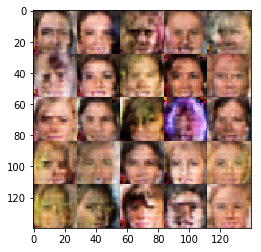

Epoch 0/1... Discriminator Loss: 1.3407... Generator Loss: 0.8171
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.6105
Epoch 0/1... Discriminator Loss: 1.3593... Generator Loss: 0.5908
Epoch 0/1... Discriminator Loss: 1.4104... Generator Loss: 0.7739
Epoch 0/1... Discriminator Loss: 1.2980... Generator Loss: 1.0427
Epoch 0/1... Discriminator Loss: 1.3268... Generator Loss: 0.6598
Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.5545
Epoch 0/1... Discriminator Loss: 1.1378... Generator Loss: 0.8636
Epoch 0/1... Discriminator Loss: 1.3303... Generator Loss: 0.5256
Epoch 0/1... Discriminator Loss: 1.3470... Generator Loss: 0.5721


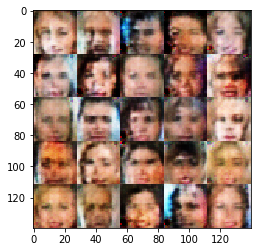

Epoch 0/1... Discriminator Loss: 1.2892... Generator Loss: 0.6758
Epoch 0/1... Discriminator Loss: 1.2648... Generator Loss: 0.7395
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.5483
Epoch 0/1... Discriminator Loss: 1.5979... Generator Loss: 0.8771
Epoch 0/1... Discriminator Loss: 1.3853... Generator Loss: 0.6982
Epoch 0/1... Discriminator Loss: 1.3304... Generator Loss: 0.7103
Epoch 0/1... Discriminator Loss: 1.2960... Generator Loss: 0.7805
Epoch 0/1... Discriminator Loss: 1.4108... Generator Loss: 0.5636
Epoch 0/1... Discriminator Loss: 1.3218... Generator Loss: 0.7232
Epoch 0/1... Discriminator Loss: 1.4120... Generator Loss: 0.6151


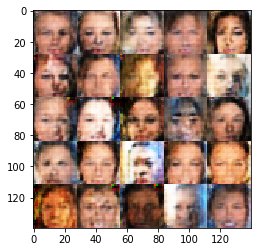

Epoch 0/1... Discriminator Loss: 1.3882... Generator Loss: 0.6623
Epoch 0/1... Discriminator Loss: 1.3364... Generator Loss: 0.7272
Epoch 0/1... Discriminator Loss: 1.3631... Generator Loss: 0.6816
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.7040
Epoch 0/1... Discriminator Loss: 1.3067... Generator Loss: 0.6162
Epoch 0/1... Discriminator Loss: 1.3922... Generator Loss: 0.5551
Epoch 0/1... Discriminator Loss: 1.2740... Generator Loss: 0.6498
Epoch 0/1... Discriminator Loss: 1.3832... Generator Loss: 0.6874
Epoch 0/1... Discriminator Loss: 1.2554... Generator Loss: 0.7411
Epoch 0/1... Discriminator Loss: 1.3010... Generator Loss: 0.6951


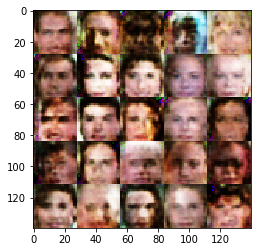

Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.6849
Epoch 0/1... Discriminator Loss: 1.3485... Generator Loss: 0.5677
Epoch 0/1... Discriminator Loss: 1.3499... Generator Loss: 0.6850
Epoch 0/1... Discriminator Loss: 1.2693... Generator Loss: 1.0271
Epoch 0/1... Discriminator Loss: 1.3524... Generator Loss: 0.8087
Epoch 0/1... Discriminator Loss: 1.3789... Generator Loss: 0.7737
Epoch 0/1... Discriminator Loss: 1.4359... Generator Loss: 0.5503
Epoch 0/1... Discriminator Loss: 1.3174... Generator Loss: 0.6830
Epoch 0/1... Discriminator Loss: 1.3592... Generator Loss: 0.6931
Epoch 0/1... Discriminator Loss: 1.3439... Generator Loss: 0.6287


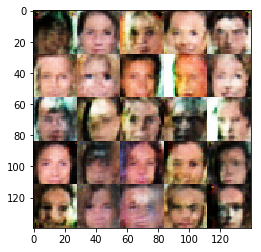

Epoch 0/1... Discriminator Loss: 1.2990... Generator Loss: 0.7297
Epoch 0/1... Discriminator Loss: 1.3771... Generator Loss: 0.6968
Epoch 0/1... Discriminator Loss: 1.2899... Generator Loss: 1.0158
Epoch 0/1... Discriminator Loss: 1.3558... Generator Loss: 0.6704
Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.8466
Epoch 0/1... Discriminator Loss: 1.3343... Generator Loss: 0.6512
Epoch 0/1... Discriminator Loss: 1.3670... Generator Loss: 0.6820
Epoch 0/1... Discriminator Loss: 1.2696... Generator Loss: 0.6845
Epoch 0/1... Discriminator Loss: 1.6761... Generator Loss: 0.6118
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.6967


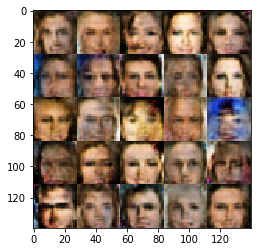

Epoch 0/1... Discriminator Loss: 1.3546... Generator Loss: 0.7120
Epoch 0/1... Discriminator Loss: 1.3801... Generator Loss: 0.6146
Epoch 0/1... Discriminator Loss: 1.4349... Generator Loss: 0.6566
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7043
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.6850
Epoch 0/1... Discriminator Loss: 1.3886... Generator Loss: 0.6815
Epoch 0/1... Discriminator Loss: 1.3852... Generator Loss: 0.7262
Epoch 0/1... Discriminator Loss: 1.2951... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 1.2954... Generator Loss: 0.7038
Epoch 0/1... Discriminator Loss: 1.3865... Generator Loss: 0.6961


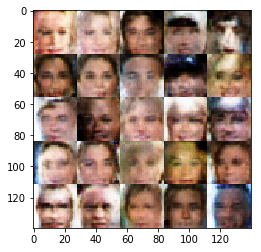

Epoch 0/1... Discriminator Loss: 1.4522... Generator Loss: 0.8014
Epoch 0/1... Discriminator Loss: 1.2964... Generator Loss: 0.8275
Epoch 0/1... Discriminator Loss: 1.5934... Generator Loss: 0.5118
Epoch 0/1... Discriminator Loss: 1.3549... Generator Loss: 0.7779
Epoch 0/1... Discriminator Loss: 1.4277... Generator Loss: 0.5746
Epoch 0/1... Discriminator Loss: 1.3577... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 1.3354... Generator Loss: 0.7741
Epoch 0/1... Discriminator Loss: 1.3119... Generator Loss: 0.6881
Epoch 0/1... Discriminator Loss: 1.3004... Generator Loss: 0.7326
Epoch 0/1... Discriminator Loss: 1.3317... Generator Loss: 0.6893


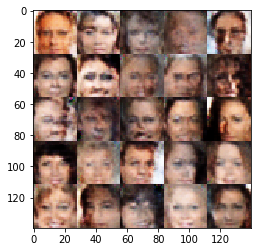

Epoch 0/1... Discriminator Loss: 1.3301... Generator Loss: 0.6832
Epoch 0/1... Discriminator Loss: 1.3644... Generator Loss: 0.5977
Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.8755
Epoch 0/1... Discriminator Loss: 1.3930... Generator Loss: 0.6312
Epoch 0/1... Discriminator Loss: 1.3611... Generator Loss: 0.7150
Epoch 0/1... Discriminator Loss: 1.3174... Generator Loss: 0.7399
Epoch 0/1... Discriminator Loss: 1.4035... Generator Loss: 0.6056
Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.6868
Epoch 0/1... Discriminator Loss: 1.3317... Generator Loss: 0.7095
Epoch 0/1... Discriminator Loss: 1.3357... Generator Loss: 0.7217


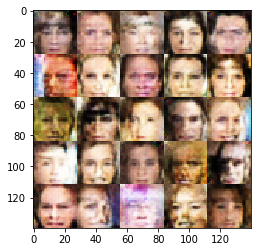

Epoch 0/1... Discriminator Loss: 1.3575... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.3690... Generator Loss: 0.6677
Epoch 0/1... Discriminator Loss: 1.4636... Generator Loss: 0.6473
Epoch 0/1... Discriminator Loss: 1.4023... Generator Loss: 0.6749
Epoch 0/1... Discriminator Loss: 1.3289... Generator Loss: 0.7008
Epoch 0/1... Discriminator Loss: 1.4339... Generator Loss: 0.6580
Epoch 0/1... Discriminator Loss: 1.3528... Generator Loss: 0.7066
Epoch 0/1... Discriminator Loss: 1.3850... Generator Loss: 0.6817
Epoch 0/1... Discriminator Loss: 1.3218... Generator Loss: 0.7807
Epoch 0/1... Discriminator Loss: 1.3738... Generator Loss: 0.6689


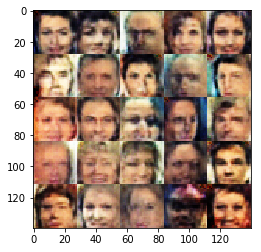

Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.6700
Epoch 0/1... Discriminator Loss: 1.3867... Generator Loss: 0.6452
Epoch 0/1... Discriminator Loss: 1.3544... Generator Loss: 0.6970
Epoch 0/1... Discriminator Loss: 1.3729... Generator Loss: 0.6798
Epoch 0/1... Discriminator Loss: 1.3396... Generator Loss: 0.7056
Epoch 0/1... Discriminator Loss: 1.3418... Generator Loss: 0.6966
Epoch 0/1... Discriminator Loss: 1.4042... Generator Loss: 0.6371
Epoch 0/1... Discriminator Loss: 1.4537... Generator Loss: 0.6101
Epoch 0/1... Discriminator Loss: 1.3975... Generator Loss: 0.6873
Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 0.7604


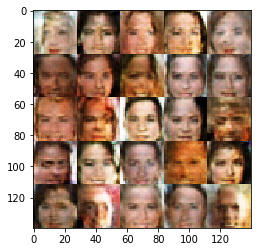

Epoch 0/1... Discriminator Loss: 1.3156... Generator Loss: 0.7370
Epoch 0/1... Discriminator Loss: 1.2878... Generator Loss: 0.7018
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.7279
Epoch 0/1... Discriminator Loss: 1.3524... Generator Loss: 0.7846
Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.6743
Epoch 0/1... Discriminator Loss: 1.3757... Generator Loss: 0.7154
Epoch 0/1... Discriminator Loss: 1.3611... Generator Loss: 0.7107
Epoch 0/1... Discriminator Loss: 1.4102... Generator Loss: 0.6707
Epoch 0/1... Discriminator Loss: 1.3690... Generator Loss: 0.7355
Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.7232


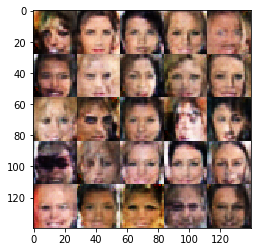

Epoch 0/1... Discriminator Loss: 1.3720... Generator Loss: 0.6962
Epoch 0/1... Discriminator Loss: 1.4262... Generator Loss: 0.6616
Epoch 0/1... Discriminator Loss: 1.3536... Generator Loss: 0.6927
Epoch 0/1... Discriminator Loss: 1.4424... Generator Loss: 0.6463
Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 0.6898
Epoch 0/1... Discriminator Loss: 1.3495... Generator Loss: 0.7266
Epoch 0/1... Discriminator Loss: 1.4291... Generator Loss: 0.6432
Epoch 0/1... Discriminator Loss: 1.3630... Generator Loss: 0.7221
Epoch 0/1... Discriminator Loss: 1.4258... Generator Loss: 0.7256
Epoch 0/1... Discriminator Loss: 1.2999... Generator Loss: 0.7554


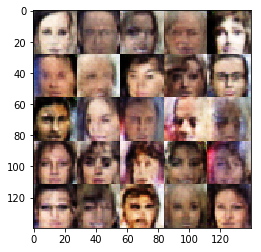

Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.7121
Epoch 0/1... Discriminator Loss: 1.3037... Generator Loss: 0.7345
Epoch 0/1... Discriminator Loss: 1.4776... Generator Loss: 0.5662
Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.7477
Epoch 0/1... Discriminator Loss: 1.4337... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 1.3269... Generator Loss: 0.7293
Epoch 0/1... Discriminator Loss: 1.4714... Generator Loss: 0.6241
Epoch 0/1... Discriminator Loss: 1.3195... Generator Loss: 0.7018
Epoch 0/1... Discriminator Loss: 1.3704... Generator Loss: 0.7119
Epoch 0/1... Discriminator Loss: 1.3474... Generator Loss: 0.7037


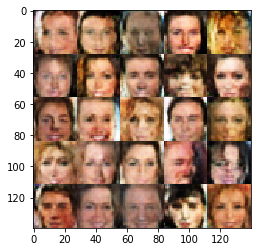

Epoch 0/1... Discriminator Loss: 1.2947... Generator Loss: 0.7676
Epoch 0/1... Discriminator Loss: 1.3650... Generator Loss: 0.7042
Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 0.6996
Epoch 0/1... Discriminator Loss: 1.4252... Generator Loss: 0.6658
Epoch 0/1... Discriminator Loss: 1.4449... Generator Loss: 0.6544
Epoch 0/1... Discriminator Loss: 1.3679... Generator Loss: 0.6745
Epoch 0/1... Discriminator Loss: 1.3563... Generator Loss: 0.7050
Epoch 0/1... Discriminator Loss: 1.3912... Generator Loss: 0.6915
Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.6772
Epoch 0/1... Discriminator Loss: 1.4041... Generator Loss: 0.7039


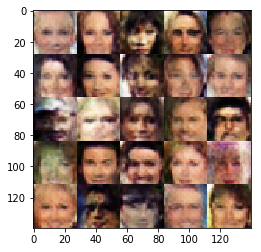

Epoch 0/1... Discriminator Loss: 1.3637... Generator Loss: 0.7258
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 0.7026
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.7025
Epoch 0/1... Discriminator Loss: 1.3353... Generator Loss: 0.7917
Epoch 0/1... Discriminator Loss: 1.3490... Generator Loss: 0.7570
Epoch 0/1... Discriminator Loss: 1.3354... Generator Loss: 0.6998
Epoch 0/1... Discriminator Loss: 1.4172... Generator Loss: 0.6440
Epoch 0/1... Discriminator Loss: 1.3590... Generator Loss: 0.7123
Epoch 0/1... Discriminator Loss: 1.3257... Generator Loss: 0.7080
Epoch 0/1... Discriminator Loss: 1.3979... Generator Loss: 0.6604


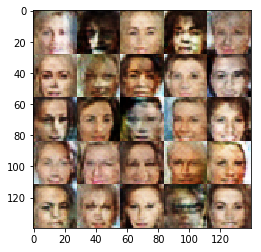

Epoch 0/1... Discriminator Loss: 1.4020... Generator Loss: 0.7235
Epoch 0/1... Discriminator Loss: 1.3588... Generator Loss: 0.6802
Epoch 0/1... Discriminator Loss: 1.3559... Generator Loss: 0.7480
Epoch 0/1... Discriminator Loss: 1.4165... Generator Loss: 0.7312
Epoch 0/1... Discriminator Loss: 1.3520... Generator Loss: 0.6673
Epoch 0/1... Discriminator Loss: 1.3687... Generator Loss: 0.7321
Epoch 0/1... Discriminator Loss: 1.4766... Generator Loss: 0.6507
Epoch 0/1... Discriminator Loss: 1.3350... Generator Loss: 0.7290
Epoch 0/1... Discriminator Loss: 1.3555... Generator Loss: 0.7206
Epoch 0/1... Discriminator Loss: 1.4772... Generator Loss: 0.5800


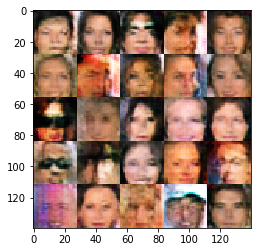

Epoch 0/1... Discriminator Loss: 1.3842... Generator Loss: 0.6660
Epoch 0/1... Discriminator Loss: 1.4276... Generator Loss: 0.6260
Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 0.7629
Epoch 0/1... Discriminator Loss: 1.4589... Generator Loss: 0.6623
Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 0.6543
Epoch 0/1... Discriminator Loss: 1.3836... Generator Loss: 0.6892
Epoch 0/1... Discriminator Loss: 1.3671... Generator Loss: 0.6448
Epoch 0/1... Discriminator Loss: 1.4097... Generator Loss: 0.6431
Epoch 0/1... Discriminator Loss: 1.3755... Generator Loss: 0.7586
Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 0.6889


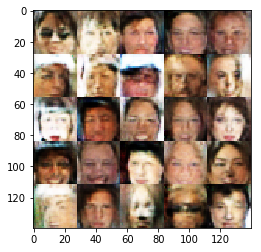

Epoch 0/1... Discriminator Loss: 1.3683... Generator Loss: 0.7073
Epoch 0/1... Discriminator Loss: 1.3634... Generator Loss: 0.6637
Epoch 0/1... Discriminator Loss: 1.3813... Generator Loss: 0.6310
Epoch 0/1... Discriminator Loss: 1.3529... Generator Loss: 0.7119
Epoch 0/1... Discriminator Loss: 1.4343... Generator Loss: 0.5862
Epoch 0/1... Discriminator Loss: 1.3828... Generator Loss: 0.7012


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.